In [2]:
import h5py as h5
import arepo
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic_2d

this is all for lvl4 runs

In [84]:
fbar_prefix_list = [
                    (5, 'lvl5-beta08-fbar008-dens-Z0'),
                    (4, 'lvl4-beta08-fbar008-dens-Z0'),
                    (3, 'lvl3-beta08-fbar008-dens-Z0'),
                    ]

fbar_list = [l[0] for l in fbar_prefix_list]
prefix_list = [l[1] for l in fbar_prefix_list]

idx_list = np.arange(0, 2000+1, 50)

sn_fbar = {}
for fbar,prefix in zip(fbar_list, prefix_list):
    print('loading fbar=', fbar)
    sn_fbar[fbar] = {}
    sn_fbar[fbar]['idx_list'] = []
    
    outbase = prefix + '/output'
    
    for idx in tqdm(idx_list):
        try:
            sn_fbar[fbar][idx] = arepo.Snapshot(outbase, idx, combineFiles=True)
            sn_fbar[fbar]['idx_list'].append(idx)
        except:
            break
    
    sn_fbar[fbar]['idx_list'] = np.array(sn_fbar[fbar]['idx_list'])

loading fbar= 5


100%|██████████| 41/41 [00:06<00:00,  6.61it/s]


loading fbar= 4


100%|██████████| 41/41 [00:48<00:00,  1.18s/it]


loading fbar= 3


 12%|█▏        | 5/41 [00:29<03:34,  5.96s/it]


In [4]:
def get_stellar_mass(sn):
    if sn.NumPart_Total[4] == 0:
        return 0.0
    
    is_star = sn.GFM_StellarFormationTime > 0
    if np.sum(is_star) == 0:
        return 0.0
    
    return np.sum(sn.part4.mass.value[is_star])

def weighted_median(values, weights):
    i = np.argsort(values)
    c = np.cumsum(weights[i])
    return values[i[np.searchsorted(c, 0.5 * c[-1])]]

def get_halfmass_radius(sn):
    pot_min = 0
    for pt in [0, 1, 4]:
        if sn.NumPart_Total[pt] == 0:
            continue
        part = getattr(sn, 'part'+str(pt))
        if np.min(part.pot.value) < pot_min:
            center = part.pos.value[np.argmin(part.pot.value)]
            pot_min = np.min(part.pot.value)
    
    if sn.NumPart_Total[4] == 0:
        return np.nan
    
    pos = sn.part4.pos.value - center
    mass = sn.part4.mass.value
    r = np.linalg.norm(pos, axis=1)
    
    is_star = sn.part4.GFM_StellarFormationTime > 0
    
    rhalf = weighted_median(r[is_star], mass[is_star])
    return rhalf

In [86]:
stmass = {}
for fbar in fbar_list:
    stmass[fbar] = {}
    stmass[fbar]['Time'] = []
    stmass[fbar]['StellarMass'] = []
    stmass[fbar]['HalfMassRadius'] = []
    for idx in sn_fbar[fbar]['idx_list']:
        stmass[fbar]['Time'].append(sn_fbar[fbar][idx].Time.value)
        stmass[fbar]['StellarMass'].append(get_stellar_mass(sn_fbar[fbar][idx]))
        stmass[fbar]['HalfMassRadius'].append(get_halfmass_radius(sn_fbar[fbar][idx]))
    
    for k in stmass[fbar].keys():
        stmass[fbar][k] = np.array(stmass[fbar][k])

In [6]:
3e-5/8

3.75e-06

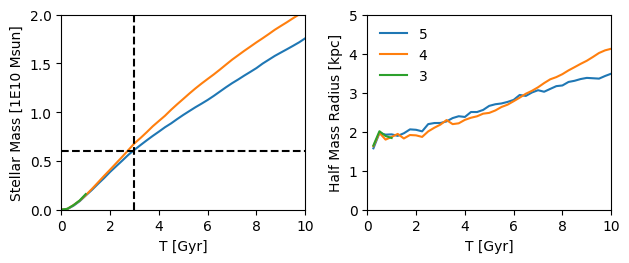

In [87]:
fig, ax = plt.subplots(1, 2, sharex=True)

fbar_plot = [5, 4, 3]

for fbar in fbar_plot:
    ax[0].plot(stmass[fbar]['Time'], stmass[fbar]['StellarMass'], label=fbar)
    ax[1].plot(stmass[fbar]['Time'], stmass[fbar]['HalfMassRadius'], label=fbar)

ax[0].set(xlim=(0, 10), ylim=(0, 2))
ax[0].set(xlabel='T [Gyr]', ylabel='Stellar Mass [1E10 Msun]')

ax[0].axhline(0.6, c='k', ls='dashed')
ax[0].axvline(3, c='k', ls='dashed')

ax[1].set(ylim=(0, 5))
ax[1].set(xlabel='T [Gyr]', ylabel='Half Mass Radius [kpc]')

asp=1.6
ax[0].set_aspect(2.5*asp)
ax[1].set_aspect(asp)

ax[1].legend(frameon=False)

fig.tight_layout()

In [75]:
ics3 = arepo.Snapshot('lvl3-beta08-fbar008-dens-Z0/ICs/MW_ICs-beta08-fbar008.dat')
# ics3 = arepo.Snapshot('lvl3-beta08-fbar008-dens-Z0/ICs/MW-beta08-fbar008.hdf5')

In [70]:
pos0 = np.array([0, 608.839, 561.009])
# pos0 -= np.array([1290/2]*3)

rdiff = np.linalg.norm(ics3.part0.pos - pos0, axis=1)
print(np.sort(rdiff)[:10])

[ 8.41458298  8.91464836  9.16754828 10.36863276 11.11719521 11.30259449
 11.76818258 13.13139233 13.52312076 13.64921859]


In [71]:
k = np.where(ics3.part0.id == 8561997)[0][0]
print(k)
print(ics3.part0.pos[k])

8561996
[1290.       608.83905  561.00854]


In [74]:
np.clip(ics3.part0.pos, 1e-6, 1290*(1-1e-6))[k]

array([1289.9987 ,  608.83905,  561.00854], dtype=float32)

In [55]:
np.where(ics3.part0.pos[:,0] == 0)

(array([], dtype=int64),)

In [60]:
np.where(ics3.part0.pos[:,0] == 1290)

(array([8561996]),)

In [61]:
np.where(ics3.part0.pos[:,1] == 0)

(array([5307261]),)

In [62]:
np.where(ics3.part0.pos[:,1] == 1290)

(array([], dtype=int64),)

In [63]:
np.where(ics3.part0.pos[:,2] == 0)

(array([], dtype=int64),)

In [64]:
np.where(ics3.part0.pos[:,2] == 1290)

(array([], dtype=int64),)

In [52]:
8561997/ics3.NumPart_Total[0]

0.768748762634595

In [78]:
ics3.BoxSize

0.0